Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

Source Kaggle Dataset: [US Accidents 2016-2023](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents)

In [27]:
accidents_df = pd.read_csv("D:/Programing/Weather2Go2/US_Accidents_March23.csv/US_Accidents_March23.csv")
accidents_df.shape


(7728394, 46)

In [28]:
accidents_df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,...,False,False,False,False,True,False,Day,Day,Day,Day


Source Weather API: [Open Meteo](https://open-meteo.com/en/docs/historical-forecast-api?bounding_box=41.7,-90.5,48.3,-82.4&start_date=2016-01-01&end_date=2023-03-31&hourly=temperature_2m,weather_code,relative_humidity_2m,surface_pressure,visibility,wind_speed_10m,precipitation&temperature_unit=fahrenheit&wind_speed_unit=mph&precipitation_unit=inch&location_mode=csv_coordinates&csv_coordinates=42.3314,-83.0458%0A42.2808,-83.7430%0A42.7325,-84.5555%0A42.9634,-85.6681%0A43.0125,-83.6875%0A42.2917,-85.5872%0A44.7631,-85.6206%0A46.5436,-87.3954%0A46.4953,-84.3453%0A)

In [29]:
weather_df = pd.read_csv("D:/Programing/Weather2Go2/Data/mi_all_hourly_2016_2023.csv")
weather_df.shape

(1757232, 10)

In [30]:
weather_df.head()

,time,temperature_2m,weather_code,relative_humidity_2m,surface_pressure,visibility,wind_speed_10m,precipitation,latitude,longitude
0,2016-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311
1,2016-01-01 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311
2,2016-01-01 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311
3,2016-01-01 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311
4,2016-01-01 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.3206,-83.0311


In [31]:
weather_df = weather_df.dropna()
weather_df.shape

(1231032, 10)

Change Kaggle Weather Conditions to more minimal categories. 

In [32]:
CATS = [
  "clear","cloudy","fog","rain_light","rain_heavy","snow_light","snow_heavy",
  "freezing_rain","sleet_mix","thunder","hail","smoke_dust","severe","other","unknown"
]

def kaggle_weather_to_cat(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return "unknown"

    s = str(x).strip().lower()

    # remove common noise tokens but keep meaning
    # (we ignore "windy" as its own category; wind is handled by wind_speed feature)
    s = s.replace("/ windy", "").replace("windy", "").strip()

    # --- highest priority: truly severe phenomena ---
    if "tornado" in s or "funnel cloud" in s:
        return "severe"
    if "squall" in s:
        return "severe"
    if "duststorm" in s:
        return "severe"

    # --- hail (including small/light/heavy) ---
    if "hail" in s:
        return "hail"

    # --- thunder / t-storm ---
    if ("thunder" in s) or ("t-storm" in s) or ("tstorm" in s) or ("thunderstorm" in s):
        return "thunder"

    # --- freezing precip (most dangerous) ---
    # freezing drizzle/rain/fog -> treat as freezing risk bucket
    if "freezing" in s:
        return "freezing_rain"

    # --- sleet / ice pellets / wintry mix ---
    if ("sleet" in s) or ("ice pellet" in s) or ("wintry mix" in s) or ("rain and sleet" in s):
        return "sleet_mix"

    # --- snow (heavy vs light) ---
    if "snow" in s or "blowing snow" in s or "drifting snow" in s or "snow grains" in s:
        if "heavy" in s:
            return "snow_heavy"
        return "snow_light"

    # --- rain/drizzle/showers (heavy vs light) ---
    if ("rain" in s) or ("drizzle" in s) or ("shower" in s):
        if "heavy" in s:
            return "rain_heavy"
        return "rain_light"

    # --- fog/mist/haze ---
    if ("fog" in s) or ("mist" in s) or ("haze" in s):
        return "fog"

    # --- smoke/dust/sand/ash ---
    if ("smoke" in s) or ("dust" in s) or ("sand" in s) or ("ash" in s) or ("volcanic" in s):
        return "smoke_dust"

    # --- clouds ---
    if ("overcast" in s) or ("cloudy" in s) or ("scattered clouds" in s) or ("partly cloudy" in s) or ("mostly cloudy" in s):
        return "cloudy"

    # --- clear/fair ---
    if ("clear" in s) or (s == "fair") or s.startswith("fair "):
        return "clear"

    # --- explicit "n/a precipitation" should not force rain ---
    if "n/a precipitation" in s:
        return "other"

    return "other"


Change [NOAA Weather Code](https://www.nodc.noaa.gov/archive/arc0021/0002199/1.1/data/0-data/HTML/WMO-CODE/WMO4677.HTM) to match simpler weather conditions.

In [33]:
def wmo_to_category(code: int) -> str:
    if code in [0]:
        return "clear"

    if code in [1, 2, 3]:
        return "cloudy"

    if code in [45, 48]:
        return "fog"

    # drizzle
    if code in [51, 53, 55]:
        return "rain_light"
    if code in [56, 57]:
        return "freezing_rain"

    # rain
    if code in [61, 63]:
        return "rain_light"
    if code in [65]:
        return "rain_heavy"
    if code in [66, 67]:
        return "freezing_rain"

    # snow
    if code in [71, 73, 77]:
        return "snow_light"
    if code in [75]:
        return "snow_heavy"

    # showers
    if code in [80, 81]:
        return "rain_light"
    if code in [82]:
        return "rain_heavy"
    if code in [85]:
        return "snow_light"
    if code in [86]:
        return "snow_heavy"

    # thunderstorms
    if code in [95]:
        return "thunder"
    if code in [96, 99]:
        return "hail"

    return "other"


Apply recode functions to both dataframes.

In [34]:
# map WMO codes -> categories on the standardized weather dataframe
weather_df['Weather_Category'] = weather_df['weather_code'].apply(wmo_to_category)

# map free-text conditions -> categories on the standardized accidents dataframe
accidents_df['Weather_Category'] = accidents_df['Weather_Condition'].apply(kaggle_weather_to_cat)

Changed both dataframes to have the same type for weather.

In [35]:
# standardize timestamp columns to timezone-aware UTC datetimes
accidents_col = 'Weather_Timestamp'
weather_time_col = 'time' if 'time' in weather_df.columns else 'Weather_Timestamp'

accidents_df[accidents_col] = pd.to_datetime(accidents_df[accidents_col], errors='coerce', utc=True)
weather_df['Weather_Timestamp'] = pd.to_datetime(weather_df[weather_time_col], errors='coerce', utc=True)

# remove original 'time' column if present to avoid confusion
if weather_time_col == 'time':
    weather_df.drop(columns=['time'], inplace=True)

# quick verification
print(accidents_df['Weather_Timestamp'].dtype, weather_df['Weather_Timestamp'].dtype)
print(accidents_df['Weather_Timestamp'].head())
print(weather_df['Weather_Timestamp'].head())

datetime64[ns, UTC] datetime64[ns, UTC]
0   2016-02-08 05:58:00+00:00
1   2016-02-08 05:51:00+00:00
2   2016-02-08 06:56:00+00:00
3   2016-02-08 07:38:00+00:00
4   2016-02-08 07:53:00+00:00
Name: Weather_Timestamp, dtype: datetime64[ns, UTC]
151940   2018-01-01 01:00:00+00:00
151941   2018-01-01 02:00:00+00:00
151942   2018-01-01 03:00:00+00:00
151943   2018-01-01 04:00:00+00:00
152684   2018-01-01 01:00:00+00:00
Name: Weather_Timestamp, dtype: datetime64[ns, UTC]


Subset to only Michigan accidents.

In [36]:
accidents_mi = accidents_df[accidents_df['State'] == 'MI']

In [37]:
accidents_subset = accidents_mi[['Weather_Timestamp','Weather_Category','Temperature(F)',
                                 'Weather_Condition','Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                                 'Wind_Speed(mph)','Precipitation(in)','Start_Lat', 'Start_Lng']].copy()

### Target
Create target of Risk based on if it was in accident df or weather df.

In [38]:
accidents_subset['Risk'] = 1
weather_df['Risk'] = 0

Rename columns to same names.

In [39]:
weather_rename = {
    "time": "Weather_Timestamp",
    "temperature_2m": "Temperature_F",
    "weather_code": "Weather_Code",
    "relative_humidity_2m": "Humidity_Pct",
    "surface_pressure": "Pressure_in",
    "visibility": "Visibility_mi",
    "wind_speed_10m": "Wind_Speed_mph",
    "precipitation": "Precipitation_in",
    "latitude": "Start_Lat",
    "longitude": "Start_Lng",
}

weather_std = weather_df.rename(columns=weather_rename)


In [40]:
accident_rename = {
    "Weather_Timestamp": "Weather_Timestamp",
    "Temperature(F)": "Temperature_F",
    "Weather_Condition": "Weather_Condition",
    "Humidity(%)": "Humidity_Pct",
    "Pressure(in)": "Pressure_in",
    "Visibility(mi)": "Visibility_mi",
    "Wind_Speed(mph)": "Wind_Speed_mph",
    "Precipitation(in)": "Precipitation_in",
    "Start_Lat": "Start_Lat",
    "Start_Lng": "Start_Lng",
}

accidents_std = accidents_subset.rename(columns=accident_rename)


In [41]:
weather_std.head()


,Temperature_F,Weather_Code,Humidity_Pct,Pressure_in,Visibility_mi,Wind_Speed_mph,Precipitation_in,Start_Lat,Start_Lng,Weather_Category,Weather_Timestamp,Risk
151940,8.936600,0.0,59.0,1010.33563,60367.453,1.703648,0.0,42.3206,-83.0311,clear,2018-01-01 01:00:00+00:00,0
151941,7.316601,0.0,63.0,1010.25240,53149.605,2.110382,0.0,42.3206,-83.0311,clear,2018-01-01 02:00:00+00:00,0
151942,5.156601,0.0,67.0,1010.04285,45931.758,1.140651,0.0,42.3206,-83.0311,clear,2018-01-01 03:00:00+00:00,0
151943,2.636601,0.0,73.0,1009.91095,38713.910,1.414803,0.0,42.3206,-83.0311,clear,2018-01-01 04:00:00+00:00,0
152684,2.769800,1.0,58.0,999.05260,63320.210,3.607054,0.0,42.2923,-83.7368,cloudy,2018-01-01 01:00:00+00:00,0


Merge together.

In [42]:
merged_df = pd.concat([accidents_std] + [weather_std], ignore_index=True, sort=False)

In [43]:
print(f'Original weather observations: {weather_std.shape[0]}')
print(f'Michigan accidents subset observations: {accidents_subset.shape[0]}')
print(f'Combined with oversampling weather: {merged_df.shape[0]}')

Original weather observations: 1231032
Michigan accidents subset observations: 162191
Combined with oversampling weather: 1393223


In [44]:
merged_df = merged_df.drop(columns=['Weather_Condition', 'Weather_Code'])

Create new columns for Day of the Week, Month, and Hour.

In [45]:
# parse timestamp, extract day/month/hour, drop original timestamp
merged_df['Weather_Timestamp_parsed'] = pd.to_datetime(merged_df['Weather_Timestamp'], errors='coerce')
merged_df['Day_of_Week'] = merged_df['Weather_Timestamp_parsed'].dt.day_name()
merged_df['Month'] = merged_df['Weather_Timestamp_parsed'].dt.month
merged_df['Hour'] = merged_df['Weather_Timestamp_parsed'].dt.hour

merged_df = merged_df.drop(columns=['Weather_Timestamp', 'Weather_Timestamp_parsed'])

In [46]:
merged_df.head()

,Weather_Category,Temperature_F,Humidity_Pct,Pressure_in,Visibility_mi,Wind_Speed_mph,Precipitation_in,Start_Lat,Start_Lng,Risk,Day_of_Week,Month,Hour
0,cloudy,43.0,60.0,29.56,10.0,15.0,NaN,42.963215,-85.666740,1,Wednesday,11.0,15.0
1,cloudy,43.0,60.0,29.56,10.0,15.0,NaN,42.955772,-85.659164,1,Wednesday,11.0,15.0
2,cloudy,48.0,80.0,29.52,10.0,4.6,NaN,43.060432,-83.783752,1,Wednesday,11.0,16.0
3,cloudy,48.0,80.0,29.52,10.0,4.6,NaN,42.942875,-83.648453,1,Wednesday,11.0,16.0
4,cloudy,55.0,69.0,29.51,10.0,10.4,NaN,42.368423,-83.058128,1,Wednesday,11.0,15.0


### Clean missing values

In [47]:
merged_df.groupby('Risk')[['Pressure_in', 'Visibility_mi']].describe()

Pressure_in                                                        \
           count        mean        std       min        25%       50%   
Risk                                                                     
0      1231032.0  987.960529  10.330536  931.7028  982.26306  989.1207   
1       161832.0   29.567576   0.490831   27.6500   29.15000   29.5100   

                            Visibility_mi                                   \
             75%        max         count          mean           std  min   
Risk                                                                         
0     994.885325  1021.5825     1231032.0  70946.739930  38591.871441  0.0   
1      30.010000    31.1500      161676.0      8.478363      2.875007  0.0   

                                               
           25%        50%       75%       max  
Risk                                           
0     46916.01  62992.125  87926.51  295275.6  
1         9.00     10.000     10.00      12.0

In [48]:
# Constants for conversion
HPA_TO_INHG = 0.02953
FT_TO_MILES = 1/5280

# Apply fixes to the Risk 0 subset
merged_df.loc[merged_df['Risk'] == 0, 'Pressure_in'] = merged_df.loc[merged_df['Risk'] == 0, 'Pressure_in'] * HPA_TO_INHG
merged_df.loc[merged_df['Risk'] == 0, 'Visibility_mi'] = merged_df.loc[merged_df['Risk'] == 0, 'Visibility_mi'] * FT_TO_MILES

In [49]:
merged_df.groupby('Risk')[['Pressure_in', 'Visibility_mi']].describe()

Pressure_in                                                        \
           count       mean       std        min        25%        50%   
Risk                                                                     
0      1231032.0  29.174474  0.305061  27.513184  29.006228  29.208734   
1       161832.0  29.567576  0.490831  27.650000  29.150000  29.510000   

                           Visibility_mi                                      \
            75%        max         count       mean       std  min       25%   
Risk                                                                           
0     29.378964  30.167331     1231032.0  13.436883  7.309067  0.0  8.885608   
1     30.010000  31.150000      161676.0   8.478363  2.875007  0.0  9.000000   

                                       
            50%        75%        max  
Risk                                   
0     11.930327  16.652748  55.923409  
1     10.000000  10.000000  12.000000

In [50]:
# Cap Risk 0 visibility at 10 miles to match Kaggle's distribution
merged_df.loc[(merged_df['Risk'] == 0) & (merged_df['Visibility_mi'] > 14), 'Visibility_mi'] = 14.0

In [51]:
merged_df.isna().sum()

Weather_Category        0
Temperature_F         454
Humidity_Pct          529
Pressure_in           359
Visibility_mi         515
Wind_Speed_mph       6683
Precipitation_in    58383
Start_Lat               0
Start_Lng               0
Risk                    0
Day_of_Week           201
Month                 201
Hour                  201
dtype: int64

In [52]:
merged_df = merged_df.drop(columns=['Precipitation_in'])

In [53]:
clean_df = merged_df.dropna()

In [54]:
risk_means = clean_df.groupby('Risk').mean(numeric_only=True)
risk_means

,Temperature_F,Humidity_Pct,Pressure_in,Visibility_mi,Wind_Speed_mph,Start_Lat,Start_Lng,Month,Hour
Risk,,,,,,,,,
0,46.364243,73.325437,29.174474,10.951811,7.442441,44.191069,-85.206572,6.309501,11.499123
1,49.530532,69.938715,29.547214,8.488449,9.389031,42.696889,-84.013787,6.564503,11.950675


In [65]:
clean_df['Visibility_mi'].groupby(clean_df['Risk']).describe()

,count,mean,std,min,25%,50%,75%,max
Risk,,,,,,,,
0,1231032.0,10.951811,3.515301,0.0,8.885608,11.930327,14.0,14.0
1,155094.0,8.488449,2.867905,0.0,9.000000,10.000000,10.0,12.0


In [55]:
clean_df = clean_df.drop(columns=['Start_Lat', 'Start_Lng'])

In [56]:
clean_df.head()

,Weather_Category,Temperature_F,Humidity_Pct,Pressure_in,Visibility_mi,Wind_Speed_mph,Risk,Day_of_Week,Month,Hour
0,cloudy,43.0,60.0,29.56,10.0,15.0,1,Wednesday,11.0,15.0
1,cloudy,43.0,60.0,29.56,10.0,15.0,1,Wednesday,11.0,15.0
2,cloudy,48.0,80.0,29.52,10.0,4.6,1,Wednesday,11.0,16.0
3,cloudy,48.0,80.0,29.52,10.0,4.6,1,Wednesday,11.0,16.0
4,cloudy,55.0,69.0,29.51,10.0,10.4,1,Wednesday,11.0,15.0


### Test Train Split

In [57]:
X = clean_df.drop(columns=['Risk'])
y = clean_df['Risk']

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')  
print(f'\nFeature columns: \n{X.columns.tolist()}')

Features shape: (1386126, 9)
Target shape: (1386126,)

Feature columns: 
['Weather_Category', 'Temperature_F', 'Humidity_Pct', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Day_of_Week', 'Month', 'Hour']


In [58]:
categorical_cols = ['Weather_Category', 'Day_of_Week']
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col])
    label_encoders[col] = le

print(f'Encoded feature columns: \n{X_encoded.columns.tolist()}')


Encoded feature columns: 
['Weather_Category', 'Temperature_F', 'Humidity_Pct', 'Pressure_in', 'Visibility_mi', 'Wind_Speed_mph', 'Day_of_Week', 'Month', 'Hour']


In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

print(f'Training features shape: {X_train.shape}')
print(f'Training target shape: {y_train.shape}')   
print(f'\nTraining set class distribution:\n{y_train.value_counts(normalize=True)}')

Training features shape: (1108900, 9)
Training target shape: (1108900,)

Training set class distribution:
Risk
0    0.88811
1    0.11189
Name: proportion, dtype: float64


### Random Forest
Hyperparameter Tuning: Grid search to find the best Random Forest settings using F1-weighted.

In [69]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [5, 10],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"],
}

rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

grid_search = GridSearchCV(rf_grid, param_grid, cv=4, scoring='f1_weighted', n_jobs=-1, verbose=1)

print("Starting GridSearchCV... (this may take a few minutes)")
grid_search.fit(X_train, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-Score: {grid_search.best_score_:.4f}")

Starting GridSearchCV... (this may take a few minutes)
Fitting 4 folds for each of 8 candidates, totalling 32 fits

Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200}
Best cross-validation F1-Score: 0.9751


In [70]:
rf_model = grid_search.best_estimator_

rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)

print("Optimized Random Forest Performance on Test Set:")
print("Accuracy:", accuracy_score(y_test, rf_pred))
print("F1 Score:", f1_score(y_test, rf_pred, average='weighted'))
print("Classification Report:")
print(classification_report(y_test, rf_pred))

Optimized Random Forest Performance on Test Set:
Accuracy: 0.9745189845108323
F1 Score: 0.9754008415468151
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    246207
           1       0.83      0.97      0.90     31019

    accuracy                           0.97    277226
   macro avg       0.91      0.97      0.94    277226
weighted avg       0.98      0.97      0.98    277226



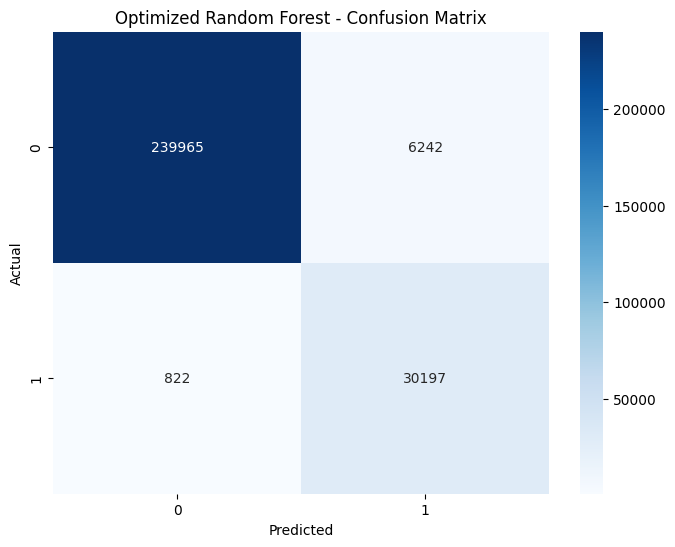

In [71]:
# Confusion Matrix for Optimized Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title('Optimized Random Forest - Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



Top 10 Most Important Features:
            Feature  Importance
4     Visibility_mi    0.647303
3       Pressure_in    0.152723
5    Wind_Speed_mph    0.078510
2      Humidity_Pct    0.056555
0  Weather_Category    0.037096
8              Hour    0.013163
1     Temperature_F    0.010337
7             Month    0.003605
6       Day_of_Week    0.000707


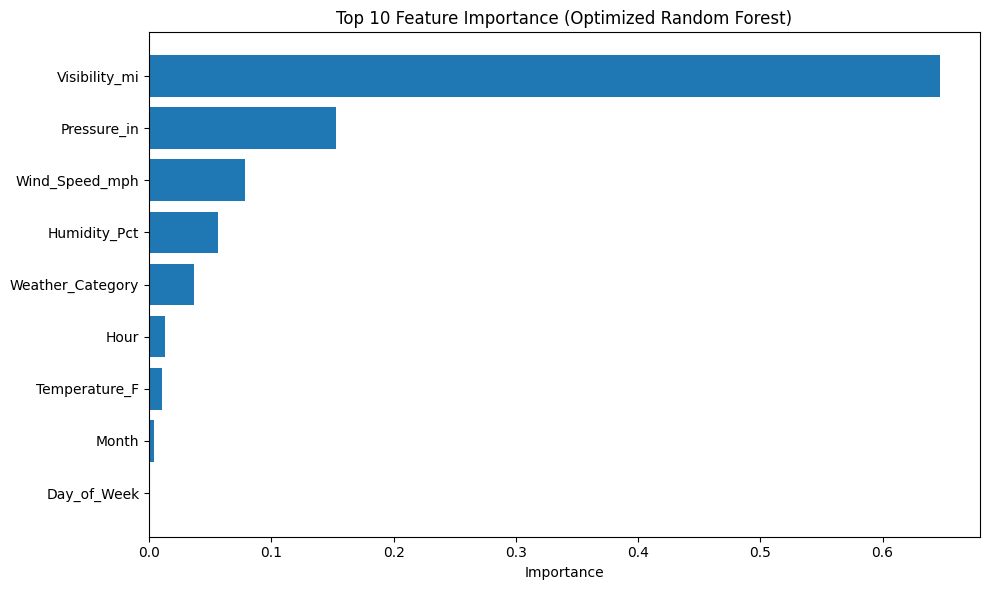

In [72]:
# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance (Optimized Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [73]:
joblib.dump(rf_model, "rf_weather_risk_model.joblib")

['rf_weather_risk_model.joblib']